In [1]:
import pyarrow.parquet as pq
import pyarrow as pa # pip install pyarrow==0.7.1
import ROOT
import numpy as np
import glob, os
from skimage.measure import block_reduce # pip install scikit-image
from numpy.lib.stride_tricks import as_strided

Welcome to JupyROOT 6.24/02


In [2]:
def upsample_array(x, b0, b1):

    r, c = x.shape                                    # number of rows/columns
    rs, cs = x.strides                                # row/column strides
    x = as_strided(x, (r, b0, c, b1), (rs, 0, cs, 0)) # view as a larger 4D array

    return x.reshape(r*b0, c*b1)/(b0*b1)              # create new 2D array with same total occupancy 

def resample_EE(imgECAL, factor=2):

    # EE-
    imgEEm = imgECAL[:140-85] # EE- in the first 55 rows
    imgEEm = np.pad(imgEEm, ((1,0),(0,0)), 'constant', constant_values=0) # for even downsampling, zero pad 55 -> 56
    imgEEm_dn = block_reduce(imgEEm, block_size=(factor, factor), func=np.sum) # downsample by summing over [factor, factor] window
    imgEEm_dn_up = upsample_array(imgEEm_dn, factor, factor)/(factor*factor) # upsample will use same values so need to correct scale by factor**2
    imgECAL[:140-85] = imgEEm_dn_up[1:] ## replace the old EE- rows

    # EE+
    imgEEp = imgECAL[140+85:] # EE+ in the last 55 rows
    imgEEp = np.pad(imgEEp, ((0,1),(0,0)), 'constant', constant_values=0) # for even downsampling, zero pad 55 -> 56
    imgEEp_dn = block_reduce(imgEEp, block_size=(factor, factor), func=np.sum) # downsample by summing over [factor, factor] window
    imgEEp_dn_up = upsample_array(imgEEp_dn, factor, factor)/(factor*factor) # upsample will use same values so need to correct scale by factor*factor
    imgECAL[140+85:] = imgEEp_dn_up[:-1] # replace the old EE+ rows

    return imgECAL

def crop_jet(imgECAL, iphi, ieta, jet_shape=125):

    # NOTE: jet_shape here should correspond to the one used in RHAnalyzer
    off = jet_shape//2
    iphi = int(iphi*5 + 2) # 5 EB xtals per HB tower
    ieta = int(ieta*5 + 2) # 5 EB xtals per HB tower

    # Wrap-around on left side
    if iphi < off:
        diff = off-iphi
        img_crop = np.concatenate((imgECAL[:,ieta-off:ieta+off+1,-diff:],
                                   imgECAL[:,ieta-off:ieta+off+1,:iphi+off+1]), axis=-1)
    # Wrap-around on right side
    elif 360-iphi < off:
        diff = off - (360-iphi)
        img_crop = np.concatenate((imgECAL[:,ieta-off:ieta+off+1,iphi-off:],
                                   imgECAL[:,ieta-off:ieta+off+1,:diff+1]), axis=-1)
    # Nominal case
    else:
        img_crop = imgECAL[:,ieta-off:ieta+off+1,iphi-off:iphi+off+1]

    return img_crop

In [3]:
infile = '/home/ruchi/e2e_tau/MLAnalyzer/convertRootFiles/DYTauTau_output_474.root'
outdir = '/home/ruchi/e2e_tau/MLAnalyzer/convertRootFiles'
decay = 'DYToTauTau_event'
idx = 1

In [4]:
rhTreeStr = infile 
rhTree = ROOT.TChain("fevt/RHTree")
rhTree.Add(rhTreeStr)
nEvts = rhTree.GetEntries()
assert nEvts > 0
print (" >> Input file:",rhTreeStr)
print (" >> nEvts:",nEvts)
outStr = '%s/%s.parquet.%d'%(outdir, decay, idx) 
print (" >> Output file:",outStr)

 >> Input file: /home/ruchi/e2e_tau/MLAnalyzer/convertRootFiles/DYTauTau_output_474.root
 >> nEvts: 486
 >> Output file: /home/ruchi/e2e_tau/MLAnalyzer/convertRootFiles/DYToTauTau_event.parquet.1


In [5]:
# Event range to process
iEvtStart = 0
iEvtEnd   = 10
#iEvtEnd   = nEvts 
assert iEvtEnd <= nEvts
print (" >> Processing entries: [",iEvtStart,"->",iEvtEnd,")")

nJets = 0
data = {} # Arrays to be written to parquet should be saved to data dict
sw = ROOT.TStopwatch()
sw.Start()
for iEvt in range(iEvtStart,iEvtEnd):

    # Initialize event
    rhTree.GetEntry(iEvt)

    if iEvt % 10 == 0:
        print (" .. Processing entry",iEvt)

    ECAL_energy = np.array(rhTree.ECAL_energy).reshape(280,360)
    ECAL_energy = resample_EE(ECAL_energy)
    HBHE_energy = np.array(rhTree.HBHE_energy).reshape(56,72)
    HBHE_energy = upsample_array(HBHE_energy, 5, 5) # (280, 360)
    TracksAtECAL_pt    = np.array(rhTree.ECAL_tracksPt_atECALfixIP).reshape(280,360)
    TracksAtECAL_dZSig = np.array(rhTree.ECAL_tracksDzSig_atECALfixIP).reshape(280,360)
    TracksAtECAL_d0Sig = np.array(rhTree.ECAL_tracksD0Sig_atECALfixIP).reshape(280,360)
    PixAtEcal_1        = np.array(rhTree.BPIX_layer1_ECAL_atPV).reshape(280,360)
    PixAtEcal_2        = np.array(rhTree.BPIX_layer2_ECAL_atPV).reshape(280,360)
    PixAtEcal_3        = np.array(rhTree.BPIX_layer3_ECAL_atPV).reshape(280,360)
    PixAtEcal_4        = np.array(rhTree.BPIX_layer4_ECAL_atPV).reshape(280,360)
    TibAtEcal_1        = np.array(rhTree.TIB_layer1_ECAL_atPV).reshape(280,360)
    TibAtEcal_2        = np.array(rhTree.TIB_layer2_ECAL_atPV).reshape(280,360)
    TobAtEcal_1        = np.array(rhTree.TOB_layer1_ECAL_atPV).reshape(280,360)
    TobAtEcal_2        = np.array(rhTree.TOB_layer2_ECAL_atPV).reshape(280,360)
    #X_CMSII            = np.stack([TracksAtECAL_pt, TracksAtECAL_dZSig, TracksAtECAL_d0Sig, ECAL_energy, HBHE_energy], axis=0) # (5, 280, 360)
    #X_CMSII            = np.stack([TracksAtECAL_pt, TracksAtECAL_dZSig, TracksAtECAL_d0Sig, ECAL_energy, HBHE_energy, PixAtEcal_1, PixAtEcal_2, PixAtEcal_3, PixAtEcal_4, TibAtEcal_1, TibAtEcal_2, TobAtEcal_1, TobAtEcal_2], axis=0) # (13, 280, 360)
    #data['X_CMSII']    = np.stack([TracksAtECAL_pt, TracksAtECAL_dZSig, TracksAtECAL_d0Sig, ECAL_energy, 
    #                               HBHE_energy, PixAtEcal_1, PixAtEcal_2, PixAtEcal_3, PixAtEcal_4, 
    #                               TibAtEcal_1, TibAtEcal_2, TobAtEcal_1, TobAtEcal_2], axis=0) # (13, 280, 360)
    data['X_CMSII']    = np.stack([TracksAtECAL_pt, ECAL_energy, HBHE_energy, PixAtEcal_1, 
                                   PixAtEcal_2, PixAtEcal_3, PixAtEcal_4], axis=0) # (7, 280, 360)
    #data['X_CMSII'] = np.stack([TracksAtECAL_pt, ECAL_energy, HBHE_energy], axis=0) # (3, 280, 360)
    #data['X_CMSII'] = np.stack([TracksAtECAL_pt, TracksAtECAL_dz, TracksAtECAL_d0, ECAL_energy], axis=0) # (4, 280, 360)
    #data['X_CMSII'] = np.stack([TracksAtECAL_pt, TracksAtECAL_dz, TracksAtECAL_d0, ECAL_energy, HBHE_energy, PixAtEcal_1, PixAtEcal_2, PixAtEcal_3, PixAtEcal_4], axis=0) # (9, 280, 360)

    # Jet attributes 
    ys      = rhTree.jet_IsTau
    jetMs   = rhTree.jet_M
    jetPts  = rhTree.jet_Pt
    dRs    = rhTree.jet_dR
    iphis  = rhTree.jetSeed_iphi
    ietas  = rhTree.jetSeed_ieta
    pdgIds = rhTree.jet_PdgIds
    njets  = len(ys)

    for i in range(njets):

        data['y']       = ys[i]
        data['jetM']    = jetMs[i]
        data['jetPt']   = jetPts[i]
        data['dR']    = dRs[i]
        data['iphi']  = iphis[i]
        data['ieta']  = ietas[i]
        data['pdgId'] = pdgIds[i]
        #data['X_jet'] = crop_jet(X_CMSII, data['iphi'], data['ieta']) # (13, 125, 125)
        #data['X_jet'] = X_CMSII # (13, 125, 125)

        # Create pyarrow.Table

        pqdata = [pa.array([d]) if (np.isscalar(d) or type(d) == list) else pa.array([d.tolist()]) for d in data.values()]

        table = pa.Table.from_arrays(pqdata, list(data.keys()))

        if nJets == 0:
            writer = pq.ParquetWriter(outStr, table.schema, compression='snappy')

        writer.write_table(table)

        nJets += 1

        print("Event:", iEvt, "  jetM:", jetMs[i], " pt:" , jetPts[i], " iPhi:", iphis[i], " iEta:", ietas[i])

writer.close()
print (" >> nJets:",nJets)
print (" >> Real time:",sw.RealTime()/60.,"minutes")
print (" >> CPU time: ",sw.CpuTime() /60.,"minutes")
print ("========================================================")

 >> Processing entries: [ 0 -> 10 )
 .. Processing entry 0
Event: 0   jetM: 5.620030403137207  pt: 33.128150939941406  iPhi: 26.0  iEta: 22.0
Event: 0   jetM: 3.4727048873901367  pt: 30.977291107177734  iPhi: 65.0  iEta: 30.0
Event: 1   jetM: 11.74865436553955  pt: 67.51908111572266  iPhi: 66.0  iEta: 35.0
Event: 1   jetM: 16.211652755737305  pt: 64.49114227294922  iPhi: 36.0  iEta: 31.0
Event: 2   jetM: 11.241612434387207  pt: 57.76510238647461  iPhi: 65.0  iEta: 18.0
Event: 2   jetM: 7.841746807098389  pt: 32.570465087890625  iPhi: 30.0  iEta: 23.0
Event: 3   jetM: 6.142031669616699  pt: 29.86079216003418  iPhi: 7.0  iEta: 38.0
Event: 4   jetM: 7.136867046356201  pt: 35.13529586791992  iPhi: 30.0  iEta: 14.0
Event: 5   jetM: 8.202526092529297  pt: 36.091590881347656  iPhi: 44.0  iEta: 13.0
Event: 6   jetM: 5.703810691833496  pt: 28.256208419799805  iPhi: 23.0  iEta: 42.0
Event: 7   jetM: 7.425912857055664  pt: 55.80294418334961  iPhi: 29.0  iEta: 13.0
Event: 7   jetM: 6.5962471961975

## Verify the output file

In [6]:
pqIn = pq.ParquetFile(outStr)
print(pqIn.metadata)
print(pqIn.schema)
X = pqIn.read_row_group(10, columns=['y','jetM','jetPt','dR','iphi','ieta','pdgId']).to_pydict()
print(X)

  created_by: parquet-cpp-arrow version 11.0.0
  num_columns: 8
  num_rows: 15
  num_row_groups: 15
  format_version: 2.6
  serialized_size: 13739
required group field_id=-1 schema {
  optional group field_id=-1 X_CMSII (List) {
    repeated group field_id=-1 list {
      optional group field_id=-1 item (List) {
        repeated group field_id=-1 list {
          optional group field_id=-1 item (List) {
            repeated group field_id=-1 list {
              optional double field_id=-1 item;
            }
          }
        }
      }
    }
  }
  optional double field_id=-1 y;
  optional double field_id=-1 jetM;
  optional double field_id=-1 jetPt;
  optional double field_id=-1 dR;
  optional double field_id=-1 iphi;
  optional double field_id=-1 ieta;
  optional double field_id=-1 pdgId;
}

{'y': [1.0], 'jetM': [7.425912857055664], 'jetPt': [55.80294418334961], 'dR': [0.047217123210430145], 'iphi': [29.0], 'ieta': [13.0], 'pdgId': [15.0]}


### Verify the shape of the X_CMSII

In [7]:
print("jetM:", data['jetM'], " pt:" , data['jetPt'], " iEta:", data['ieta'], " iphi:", data['iphi'])

jetM: 7.501258850097656  pt: 25.907506942749023  iEta: 13.0  iphi: 39.0


In [8]:
data['iphi']

39.0

In [9]:
data['X_CMSII'].shape

(7, 280, 360)

In [10]:
for i in range(data['X_CMSII'].shape[0]):
    print(i , "   ", data['X_CMSII'][i].min(), "   ", data['X_CMSII'][i].max()) 

0     0.0     14.514519
1     0.0     1.2261121
2     0.0     0.61553955
3     0.0     65.0
4     0.0     17.0
5     0.0     18.0
6     0.0     14.0


Track pt


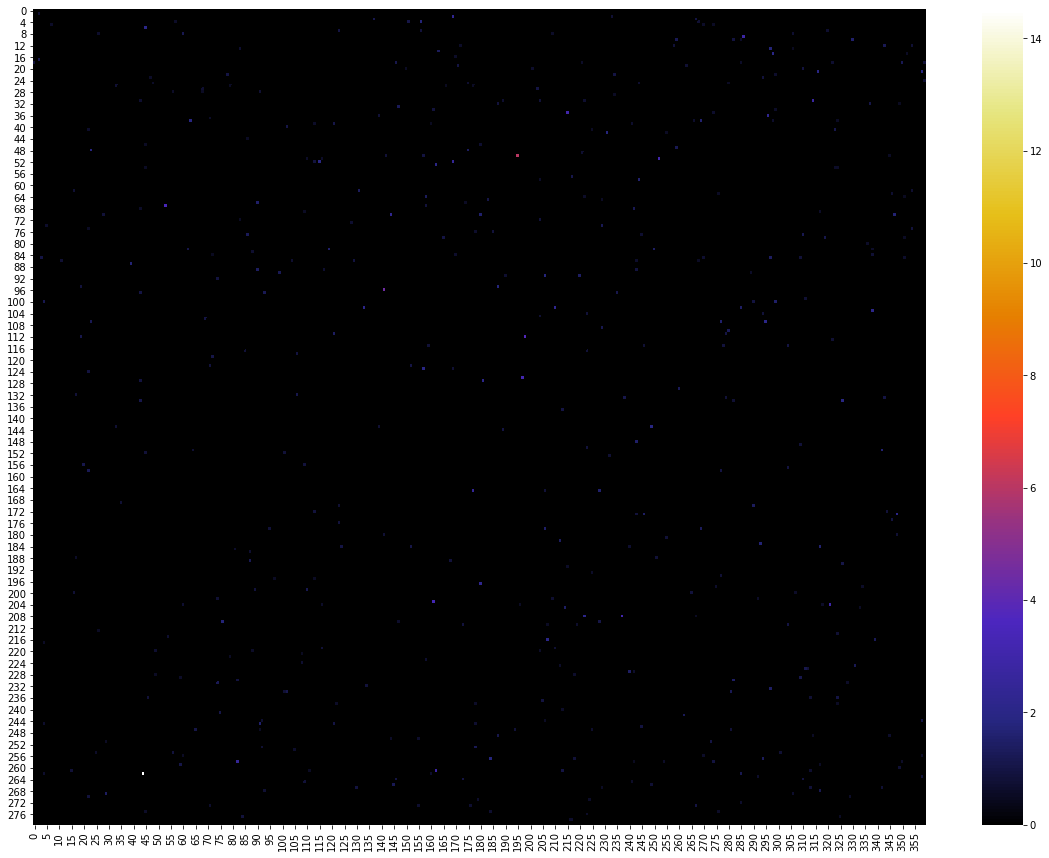

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.subplots(figsize=(20,15))
ax = sns.heatmap(data['X_CMSII'][0], cmap="CMRmap")#, vmin=0, vmax=2)#, mask=mask_shower[0])#,linecolor="blue",linewidths=0.05)
print("Track pt")

ECAL


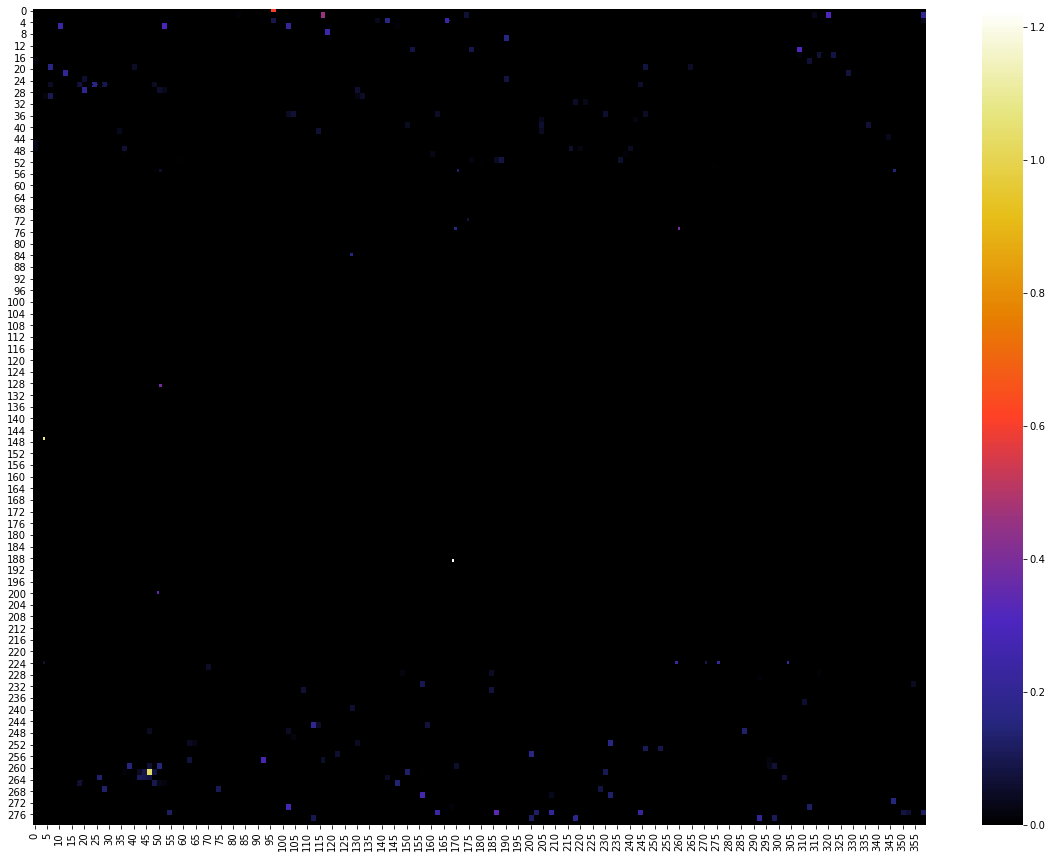

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.subplots(figsize=(20,15))
ax = sns.heatmap(data['X_CMSII'][1], cmap="CMRmap")#, vmin=0, vmax=2)#, mask=mask_shower[0])#,linecolor="blue",linewidths=0.05)
print("ECAL")

HCAL


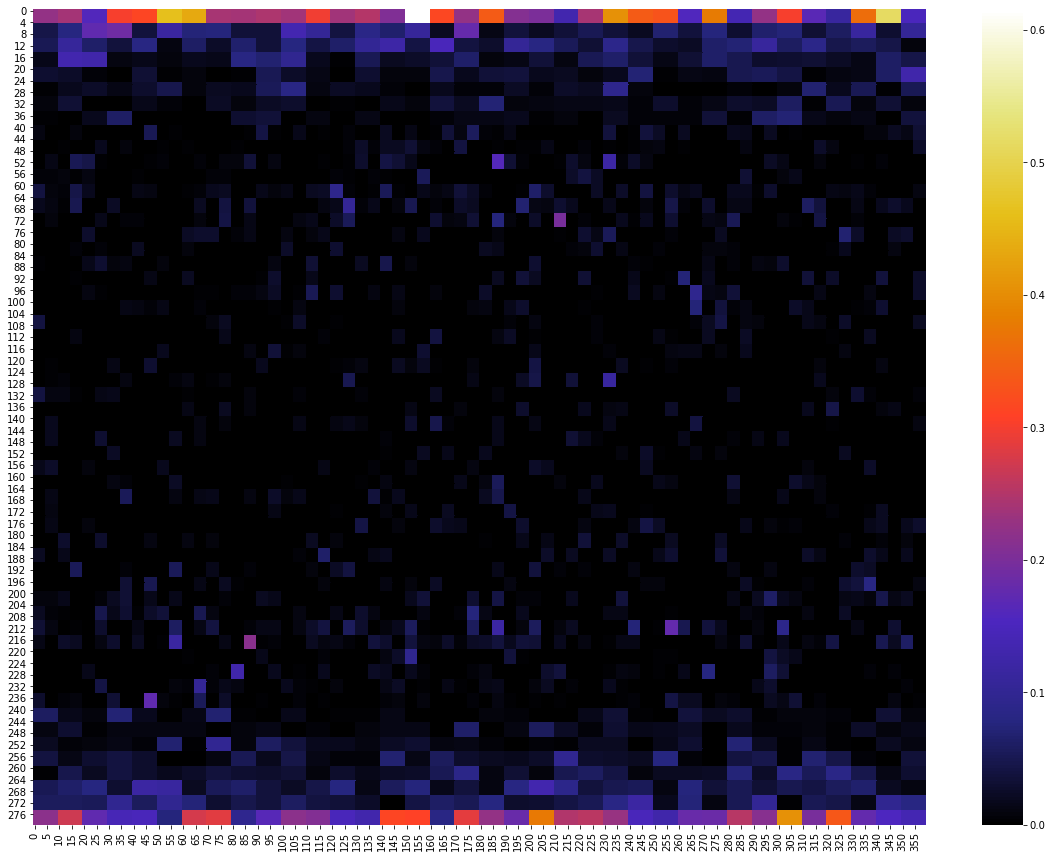

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.subplots(figsize=(20,15))
ax = sns.heatmap(data['X_CMSII'][2], cmap="CMRmap")#, vmin=0, vmax=2)#, mask=mask_shower[0])#,linecolor="blue",linewidths=0.05)
print("HCAL")